# Home Prices Prediction

This is just a quick little notebook to keep up some Python practice based on the rolling educational [Kaggle Home Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). My goal here was not so much to get a competitive score, but rather to create an effective solution that strides the middle ground of depth between analyzing all of the many variables individually (so investing a lot of time) vs just throwing everything into principal components and calling it done (i.e. the quick and dirty way). I try and describe my work as I go, so hopefully this notebook serves as a nice middle-of-the-road tutorial for others as well.

To keep that scope of effort I mention above, I employ a number of general heuristics to quickly run through all of the many variables and mostly only spot-check individual ones. Then for modelling, I choose to use a simple gradient boosted tree model only rather than hyperparam searching across many models.

## Table of Contents

* [Notebook Setup and Data Import](#NotebookSetup)
* [Cleaning Numeric Columns](#CleaningNumerics)
 * [Health Check](#HealthCheckNumerics)
 * [Handling Missing Values](#MissingNumerics)
 * [Handling Outliers](#OutliersNumerics)
* [Cleaning Categorical Columns](#CleaningCategoricals)
 * [Health Check](#HealthCheckCategoricals)
 * [Handling Missing Values](#MissingCategoricals)
 * [Ordinal Encoding](#Ordinals)
 * [OH Encoding](#OHEncodings)
* [Feature Engineering](#FeatureEngineering)
* [Model Selection](#ModelSelection)
 * [Cross-Validation Setup](#CrossValidationSetup)
 * [Hyperparameter Tuning](#HyperparameterTuning)
* [Model Prediction](#ModelPrediction)

## Notebook Setup and Data Import
<a id='NotebookSetup'></a>

In [239]:
# Library imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
sb.set()

In [240]:
# Data imports
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Always worth taking a quick glance at the data as below. We'll expect to note a number of missing values and try and queue in on any missing data types. We'll later break out our cleanup into numerical and categorical variable types.

In [241]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We'll run through all the individual feature items that we notice above in our cleaning below, but let's go ahead and look at the target variable `SalePrice` to see what we're up against.

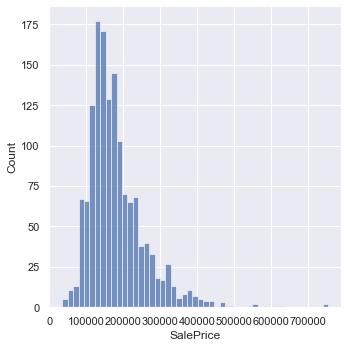

In [242]:
# Histogram of the target variable
sb.displot(df_train['SalePrice'])
plt.show()

In [243]:
# Basic statistics on the target
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There doesn't seem to be any weird prices (like negative numbers or 0), but there are definitely some rather expensive homes which might skew a regression. Given that (and in line with the competition's goals), we'll likely later want to predict the log of the home prices instead.

Let's also go ahead and define our ID and target columns so we can remove those automatically in later analysis.

In [244]:
cols_ignore = ['Id', 'SalePrice']

Time to get cleaning!

## Cleaning Numeric Columns
<a id='CleaningNumerics'></a>

### Health Check
<a id='HealthCheckNumerics'></a>

First let's just take a look at our possible numeric columns.

In [245]:
# First, define the numeric columns
cols_numeric = df_train.select_dtypes('number').columns.tolist()
cols_numeric = [col for col in cols_numeric if col not in cols_ignore] # remove ignore columns

cols_numeric

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

From a quick look at our numeric columns though, we see `MSSubClass` which really should be a categorical column per the data definitions. Let's fix that before moving on.

In [246]:
# Fix the MSSubClass column
df_train['MSSubClass'] = df_train.MSSubClass.apply(str)
df_test['MSSubClass'] = df_test.MSSubClass.apply(str)

# Then rebuild our column list
cols_numeric = df_train.select_dtypes('number').columns.tolist()
cols_numeric = [col for col in cols_numeric if col not in cols_ignore] # remove ignore columns

Now let's think about the health of these columns in more detail. Given there are so many features to explore and possibly clean, let's do a broad generic check of the "health" of the numeric columns. We can check for things like missing values, erroneously encoded values (negatives or zeroes might be an example), and outliers.

In [247]:
# Empty lists to build up a dataframe from
l_cols = []
l_outliers = []
l_negatives = []
l_zeroes = []
l_missing = []

# Iterate through our numeric columns
for col in cols_numeric:
    
    # Basic zeroes/negatives/missing checks
    zeroes = (df_train[col] == 0).sum()
    negatives = (df_train[col] < 0).sum()
    missing = df_train[col].isnull().sum()
    
    # Ouliter check using IQR method
    q25 = np.percentile(df_train[col], 25)
    q75 = np.percentile(df_train[col], 75)
    iqr = 1.5 * (q75 - q25)
    lower, upper = q25 - iqr, q75 + iqr
    outliers = ((df_train[col] < lower) | (df_train[col] > upper)).sum()
    
    # Only append if it raises some concern
    if (zeroes > 0) | (negatives > 0) | (outliers > 0) | (missing > 0):
        l_cols.append(col)
        l_outliers.append(outliers)
        l_negatives.append(negatives)
        l_zeroes.append(zeroes)
        l_missing.append(missing)

# Construct our df and check it
df_train_check = pd.DataFrame({'col':l_cols, 'outliers':l_outliers, 'missing':l_missing,
                               'negatives':l_negatives, 'zeroes':l_zeroes})
df_train_check

,col,outliers,missing,negatives,zeroes
0,LotFrontage,0,259,0,0
1,LotArea,69,0,0,0
2,OverallQual,2,0,0,0
3,OverallCond,125,0,0,0
4,YearBuilt,7,0,0,0
5,MasVnrArea,0,8,0,861
6,BsmtFinSF1,7,0,0,467
7,BsmtFinSF2,167,0,0,1293
8,BsmtUnfSF,29,0,0,118
9,TotalBsmtSF,61,0,0,37


A few notes from quickly surveying the above:
* There are no surprising negative encodings.
* While there are a number of columns with zeroes, but these makes reasonable sense with the data definitions.
* There are 3 columns with missing values.
* There are a large number of columns with outliers. We'll need a strategy for addressing those.

As such, we'll focus our cleaning efforts on handling missing values and outliers.

### Handling Missing Numerics
<a id='MissingNumerics'></a>

In our train dataset, we've only got 3 numerics with missing values.

In [248]:
cols_numeric_missing = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Let's run a quick distribution check on each.

LotFrontage
Missing: 259


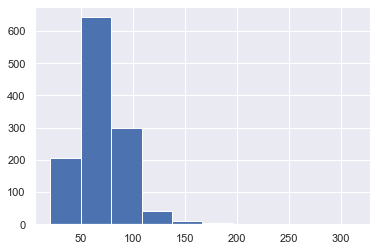

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

MasVnrArea
Missing: 8


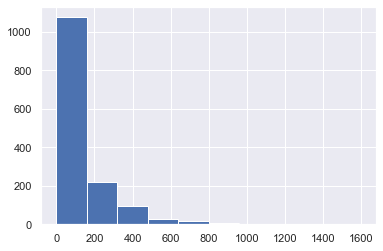

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

GarageYrBlt
Missing: 81


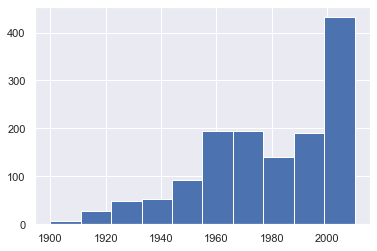

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64



In [249]:
# Define our report function
def nullcheck(col):
    
    print(col)
    print('Missing: {}'.format(df_train[col].isnull().sum()))
    df_train[col].hist()
    plt.show()
    print(df_train[col].describe())
    print()

# Run the check on our columns
for col in cols_numeric_missing:
    
    nullcheck(col)

From looking at the these distributions and the data definitions, it's clear that some columns make reasonable sense to be imputed with 0s (i.e. `MasVnrArea` where the implication is that they are missing that housing feature), but for others 0 imputation would be odd (i.e. `GarageYrBlt` which should be nonzero). While there are only 3 numeric columns with missing data in the training set, more data might come in missing for the test (or production) set also. We can see this if we check the test set below.

In [250]:
# Numeric columns with nulls in the test set
df_test[cols_numeric].columns[df_test[cols_numeric].isnull().any()]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

As such, we should set a strategy that could reasonably handle all numeric columns if need be.

Let's then create two lists of numerics, one to be zero imputed and another to be median imputed. For median imputation, we might group by the `Neighborhood` field to get more specific results.

In a real-world case, the median imputation would ideally be part of the validation step (i.e. within each cross validation fold) to prevent information leakage. However, since we're likely to do a lot of feature engineering here and this is just an example notebook, we'll cut ourselves some slack.

Given there are a lot of features to run through, we might develop a heuristic to populate our lists - *If the min of a column is 0, use 0 imputation. If not, use median imputation*.

In [251]:
# Set up our column lists
cols_numeric_0 = [col for col in cols_numeric if df_train[col].min() == 0]
cols_numeric_med = [col for col in cols_numeric if col not in cols_numeric_0]

# Sanity check their lenghts
print('Zero Imputation: ' + str(len(cols_numeric_0)))
print('Median Imputation: ' + str(len(cols_numeric_med)))

Zero Imputation: 23
Median Imputation: 12


In [252]:
# Perform zero imputation for train and test
df_train[cols_numeric_0] = df_train[cols_numeric_0].fillna(0)
df_test[cols_numeric_0] = df_test[cols_numeric_0].fillna(0)

Again for the median imputation, if we wanted truly generalizable test scores, we should not even use simple distribution information from the test set. Since our test set is really just a kaggle test set here though, we'll median impute across our whole dataspace.

Were this something we intended to put in production, we'd want to essentially learn the medians from the train set only and apply those to the test set. This could be done by some fit/transform object (Sklearn has a few). In this case though, like the cross validation consideration, we'll go easy on ourselves.

In [253]:
# Append both dataframes
df_both = df_train.append(df_test)

# Iterate through the median-imputation columns and fill
for col in cols_numeric_med:
    
    filled_series = df_both.groupby('Neighborhood')[col].transform(lambda x: x.fillna(x.median()))
    df_train[col] = filled_series[:len(df_train)] # Slice the length of the training set to get the train values
    df_test[col] = filled_series[:len(df_test)] # And similarly for the test set

In [254]:
# Finally, sanity check our numeric columns for nulls
df_train[cols_numeric].isnull().any()

LotFrontage      False
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea       False
BsmtFinSF1       False
BsmtFinSF2       False
BsmtUnfSF        False
TotalBsmtSF      False
1stFlrSF         False
2ndFlrSF         False
LowQualFinSF     False
GrLivArea        False
BsmtFullBath     False
BsmtHalfBath     False
FullBath         False
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr     False
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt      False
GarageCars       False
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
MoSold           False
YrSold           False
dtype: bool

### Handling Outliers
<a id='OutliersNumerics'></a>

For addressing the outliers, we might try an empirical approach of simply dropping those automatically in training since we don't have time to inspect all of these manually. To do that though, it would be good to have a rough idea of how much data we lose when dropping outliers.

However, if we do so blindly, we're likely to lose most of our data due to columns with a heavy prevalence of 0s. We can this by looking at the `ScreenPorch` feature.

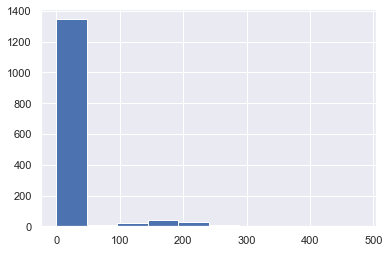

In [255]:
df_train.ScreenPorch.hist();

For a lot of features like `ScreenPorch`, most values will be 0 (i.e. here they don't have a screen porch). As such, all nonzero values will register as outliers, but that's not really what we're interested in. More interesting would be to find outliers based on the nonzero distribution. We can do that by filtering out the 0s for columns that have a median of 0 when doing our outlier checks.

Given the featureset, we're also likely to run into a number of distributions where almost all the values fall into a few distinct values. We can see that with `KitchenAbvGr` below.

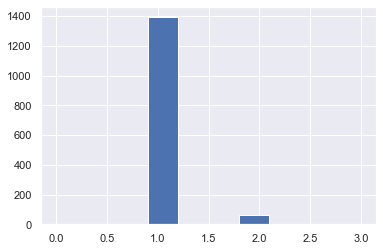

In [256]:
df_train.KitchenAbvGr.hist();

While technically the value of 2 above is an outlier using the IQR method, variables like these often function like ordinal or categorical levels and carry good information within them. Removing outliers like this isn't likely getting rid of bogus data or items that would throw off the model. We could instead only check features that have more than 5 distinct values. It's not a perfect heuristic, but it will handle a lot of the cases given we have a lot of numerical features to go through.

With our general strategy in place, we can iterate over different definitions of "outlier" (by picking a different multiple of the IQR), dropping the record if there is an outlier in any column, and then seeing how much data is left.

In [257]:
# Get our list of columns to check
cols_outlier_check = [col for col in cols_numeric if df_train[col].nunique() > 5]

# Some setup variables
rcount = len(df_train)
iqr_mults = [1.5, 3, 6, 9, 18, 27, 100]

# Iterate through both the iqr multiplicatives and columns to check
for mult in iqr_mults:
    
    mask = np.ones(rcount, dtype=bool) # A dummy array to keep track of non-missing values

    for col in cols_outlier_check:
        
        # If the median for the column is 0, only look at the nonzero values
        center = df_train[col].median()
        if center == 0:
            col_data = df_train[col][df_train[col] != 0]
        else:
            col_data = df_train[col]
        
        # Fina the IQR ranges
        q25 = np.percentile(col_data, 25)
        q75 = np.percentile(col_data, 75)
        iqr = mult * (q75 - q25)
        lower, upper = q25 - iqr, q75 + iqr
        
        # Update the dummary array with which are and aren't outliers
        not_outliers = ~(
            (df_train[col] != 0) & # Don't consider the 0s in the outlier sets
            ((df_train[col] < lower) | (df_train[col] > upper))
            )
        mask = mask & not_outliers
    
    # Calculate and print the results
    perc = (mask.sum() / rcount) * 100
    print('IQR Mult: {}, Percent Retained: {}'.format(mult, perc))

IQR Mult: 1.5, Percent Retained: 70.27397260273973
IQR Mult: 3, Percent Retained: 94.65753424657535
IQR Mult: 6, Percent Retained: 98.4931506849315
IQR Mult: 9, Percent Retained: 99.04109589041096
IQR Mult: 18, Percent Retained: 99.65753424657534
IQR Mult: 27, Percent Retained: 99.72602739726028
IQR Mult: 100, Percent Retained: 100.0


Looks like if we used IQR multipliers of 1.5, 6, and 18 then we'll get a good spread to check. This will need to be done within cross validation though as we'll want to drop the values in the training sets but retain them in the testing sets. For now though, we have a reasonable strategy.

## Cleaning Categorical (NonNumeric) Columns
<a id='CleaningCategoricals'></a>

### Health Check
<a id='HealthCheckCategoricals'></a>

In checking the data definitions, it doesn't look like we have any long text fields or datetime columns. Implicitly we can assume most of the remaining data is categorical. Let's first check how many we have to draw up a strategy.

In [258]:
# List our categorical columns and check the length
cols_cat = list(set(df_train.columns.tolist()) - set(cols_ignore) - set(cols_numeric))

print(len(cols_cat))

44


That's quite a lot to look through. We'll run a high-level health check below, but for the sake of time we should focus A) concerns that can be identified by a quick sampling of the data, and B) the number of levels we'll have to encode.

In [259]:
# Counter variable to keep the running total of categorical levels
level_count = 0

# Iterate through each categorical column
for col in cols_cat:
    
    # Grab the distinct levels and increase the running total
    levels = df_train[col].nunique()
    level_count += levels
    
    # Show the level amount, number of missing records, and a quick sample
    print(col)
    print(str(levels) + ' levels.')
    print(str(df_train[col].isnull().sum()) + ' missing records.')
    print(df_train[col].sample(5))
    print()
    
# Print the overall level count (i.e. if we one-hot encoded everything)
print('Total levels: ' + str(level_count))

LandSlope
3 levels.
0 missing records.
260     Gtl
235     Gtl
1310    Gtl
813     Gtl
923     Gtl
Name: LandSlope, dtype: object

Electrical
5 levels.
1 missing records.
1184    SBrkr
390     SBrkr
97      FuseF
586     SBrkr
1436    SBrkr
Name: Electrical, dtype: object

BsmtCond
4 levels.
37 missing records.
794    TA
903    TA
762    TA
68     TA
988    TA
Name: BsmtCond, dtype: object

MiscFeature
4 levels.
1406 missing records.
223     NaN
1181    NaN
162     NaN
775     NaN
1139    NaN
Name: MiscFeature, dtype: object

MasVnrType
4 levels.
8 missing records.
609      BrkCmn
1336    BrkFace
329        None
843        None
16      BrkFace
Name: MasVnrType, dtype: object

FireplaceQu
5 levels.
690 missing records.
1278     Gd
856     NaN
910     NaN
596     NaN
558      TA
Name: FireplaceQu, dtype: object

MSSubClass
15 levels.
0 missing records.
5        50
154      30
1010     50
291     190
994      20
Name: MSSubClass, dtype: object

HouseStyle
8 levels.
0 missing records.
1356

From the above, we can identify a few key points without having to get too into the weeds on each columns:

* There are a number of columns with missing values. Interestingly, these match up well with an expected 'NA' for nearly all columns per the data dictionary.
* A lot of these look like they might be better encoded ordinally which matches with a number of the data definitions (i.e. concepts like "Excellent -> Good -> Fair").
* If we one-hot encoded *all* of these columns, we'd still only end up with ~270 levels. After turning some variables into ordinals, this will be even smaller, making it a pretty reasonable approach.

While there's likely a number of other items that could be addressed (i.e. looking for mispellings in the levels), this is a reasonable time-conscientious approach.

### Handling Missing Values
<a id='MissingCategoricals'></a>

We can do a very simple missing fill of 'NA'. This is likely to miss some cases, but given the notes in the data dictionary and the volume of columns to look through, this should catch most concerns.

In [260]:
# Run the fill
df_train[cols_cat] = df_train[cols_cat].fillna('NA')
df_test[cols_cat] = df_test[cols_cat].fillna('NA')

# Sanity check no missing left
df_train[cols_cat].isnull().any()

LandSlope        False
Electrical       False
BsmtCond         False
MiscFeature      False
MasVnrType       False
FireplaceQu      False
MSSubClass       False
HouseStyle       False
Fence            False
PoolQC           False
Exterior1st      False
Foundation       False
Neighborhood     False
Alley            False
PavedDrive       False
BsmtFinType2     False
BldgType         False
HeatingQC        False
GarageFinish     False
Utilities        False
SaleCondition    False
GarageCond       False
LotShape         False
ExterCond        False
GarageType       False
Heating          False
BsmtQual         False
MSZoning         False
GarageQual       False
Exterior2nd      False
Functional       False
Street           False
SaleType         False
BsmtExposure     False
RoofMatl         False
LotConfig        False
RoofStyle        False
Condition1       False
KitchenQual      False
LandContour      False
ExterQual        False
CentralAir       False
BsmtFinType1     False
Condition2 

### Handling Ordinal Encodings
<a id='Ordinals'></a>

Using the data dictionary, we can build up our own dictionary to remap strings in ordinal encodings. We'll use the same dictionary for all features unless there is overlap (then we'll spin out another). For all other columns we'll one-hot encode.

In [261]:
# For generic mapping, each new line represents a separate field
map_generic = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, # For most mappings
               'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3, # For LotShape column
               'Gtl':0, 'Mod':1, 'Sev':2, # For LandSlope column
               'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6, # ForBsmtFinType 1 & 2, starts with 'NA'
               'RFn':2, 'Fin': 3, # For GarageFinish, starts with 'NA' and 'Unf'
               'N':0, 'P':1, 'Y':2 # For PavedDrive
              }

# For the 'Functional' column
map_functional = {'Typ':7, 'NA':7, # Here if we found an NA we might assume it's typical
                  'Min1':6,
                  'Min2':5,
                  'Mod':4,
                  'Maj1':3,
                  'Maj2':2,
                  'Sev':1,
                  'Sal':0}

# For the 'BsmtExposure' column
map_bsmt = {'Gd':4,
            'Av':3,
            'Mn':2,
            'No':1,
            'NA':0}

In [262]:
# Create a list of the generic columns we'll remap
cols_cat_maps = ['ExterCond',
                'ExterQual',
                'FireplaceQu',
                'BsmtQual',
                'BsmtCond',
                'KitchenQual',
                'PoolQC',
                'HeatingQC',
                'GarageCond',
                'GarageQual',
                'LotShape',
                'LandSlope',
                'BsmtFinType1',
                'BsmtFinType2',
                'GarageFinish',
                'PavedDrive']

In [263]:
# Remap the generic columns
for df in [df_train, df_test]:
    
    for col in cols_cat_maps:
        
        df[col] = df[col].replace(map_generic).astype('int32')
        
# Remap the functional column
df_train['Functional'] = df_train['Functional'].replace(map_functional).astype('int32')
df_test['Functional'] = df_test['Functional'].replace(map_functional).astype('int32')

# Remap the basement exposure column
df_train['BsmtExposure'] = df_train['BsmtExposure'].replace(map_bsmt).astype('int32')
df_test['BsmtExposure'] = df_test['BsmtExposure'].replace(map_bsmt).astype('int32')

Let's rebuild our categorical column list now that we're done.

In [264]:
# Subtract out the new ordinal columns from the categorical list
new_ordinals = cols_cat_maps + ['BsmtExposure'] + ['Functional']
cols_cat = list(set(cols_cat) - set(new_ordinals))
cols_cat

['Electrical',
 'MiscFeature',
 'MasVnrType',
 'MSSubClass',
 'HouseStyle',
 'Fence',
 'Foundation',
 'Exterior1st',
 'Neighborhood',
 'Alley',
 'BldgType',
 'Utilities',
 'SaleCondition',
 'Heating',
 'GarageType',
 'MSZoning',
 'Exterior2nd',
 'Street',
 'SaleType',
 'RoofMatl',
 'LotConfig',
 'RoofStyle',
 'Condition1',
 'LandContour',
 'CentralAir',
 'Condition2']

### Handling OH Encodings
<a id='OHEncodings'></a>

Let's check how many categorical levels we'll be left with now.

In [265]:
# Run through each categorical column and get the distinct level count
level_count = 0

for col in cols_cat:
    
    level_count += df_train[col].nunique()
    
print(level_count)

193


While perhaps more than we'd like, for the number of rows in this dataset, it's quite reasonable. Since we're not putting this model in production, we can just use Pandas `get_dummies()`, but in a real-life case we'd need a fit/transform model to handle any unknown values.

In [266]:
# Append both dataframes and get the OHs
df_both = df_train.append(df_test)
OHs = pd.get_dummies(df_both[cols_cat], drop_first=True)

# Keep the onehot column names since we'll use those later
cols_OHs = OHs.columns.to_list()

# Parse back out the encoded train and test dfs
df_train = pd.concat([df_train.drop(columns=cols_cat),
                     OHs[:len(df_train)]],
                     axis=1)
df_test = pd.concat([df_test.drop(columns=cols_cat),
                    OHs[:len(df_test)]],
                    axis=1)

# Sanity check the results
df_train.head()

,Id,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,LandContour_Low,LandContour_Lvl,CentralAir_Y,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn
0,1,65.0,8450,0,0,7,5,2003,2003,196.0,...,0,1,1,0,1,0,0,0,0,0
1,2,80.0,9600,0,0,6,8,1976,1976,0.0,...,0,1,1,0,1,0,0,0,0,0
2,3,68.0,11250,1,0,7,5,2001,2002,162.0,...,0,1,1,0,1,0,0,0,0,0
3,4,60.0,9550,1,0,7,5,1915,1970,0.0,...,0,1,1,0,1,0,0,0,0,0
4,5,84.0,14260,1,0,8,5,2000,2000,350.0,...,0,1,1,0,1,0,0,0,0,0


In [267]:
# One more sanity check that there are no missing values left
df_train.isnull().any().sum(), df_test.isnull().any().sum()

(0, 0)

### Feature Engineering
<a id='FeatureEngineering'></a>

There are a number of possible new columns we might create using a little intuition about factors driving house prices. We'll try few below.

In [268]:
# Column to capture the total living area square feet
df_train['TotalLivingSqFt'] = df_train['TotalBsmtSF'] + df_train['GrLivArea']
df_test['TotalLivingSqFt'] = df_test['TotalBsmtSF'] + df_test['GrLivArea']

# Column to capture the total porch area
# We'll just do open + closed since there may be overlap
df_train['TotalPorchSqFt'] = df_train['OpenPorchSF'] + df_train['EnclosedPorch']
df_test['TotalPorchSqFt'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch']

# Column to capture the total bathroom count
df_train['TotalBathCount'] = df_train['FullBath'] + df_train['BsmtFullBath'] +\
    0.5 * (df_train['HalfBath'] + df_train['BsmtHalfBath'])
df_test['TotalBathCount'] = df_test['FullBath'] + df_test['BsmtFullBath'] +\
    0.5 * (df_test['HalfBath'] + df_test['BsmtHalfBath'])

# Column to represent the ratio of bedrooms to bathrooms
df_train['BedOverBath'] = (df_train['BedroomAbvGr'] + df_train['TotalBathCount']).fillna(0)
df_test['BedOverBath'] = (df_test['BedroomAbvGr'] + df_test['TotalBathCount']).fillna(0)

# Column for home age
df_train['HomeAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_test['HomeAge'] = df_test['YrSold'] - df_test['YearBuilt']

# Column for age since last remodelling
df_train['AgeLastRemod'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_test['AgeLastRemod'] = df_test['YrSold'] - df_test['YearRemodAdd']

# Column for if it was even remodelled at all
# Per the data dictionary, the remodel and construction date is the same if no remodelling
df_train['WasRemod'] = df_train.apply(lambda x: 1 if x.YearRemodAdd != x.YearBuilt else 0, axis=1)
df_test['WasRemod'] = df_test.apply(lambda x: 1 if x.YearRemodAdd != x.YearBuilt else 0, axis=1)
cols_OHs.append('WasRemod') # Keeping up with our list from previously

# Column for overall ranking
df_train['OverallScore'] = df_train['OverallQual'] + df_train['OverallCond']
df_test['OverallScore'] = df_test['OverallQual'] + df_test['OverallCond']

# Then rebuild our numeric column list since we added more
cols_numeric = df_train.select_dtypes('number').columns.tolist()
cols_numeric = [col for col in cols_numeric if (col not in cols_ignore) and (col not in cols_OHs)] # remove ignore columns

We might also wonder if some of the variables could use a transformation to more linearly match the target. There's a lot of variables to check though. As such, let's use another heuristic:  *if the spearman correlation of the variable with the target is considerably larger than the pearson correlation, it's worth checking*. Spearman corrs will catch nonmonotonic relationships and thus can suggest some worth manually plotting, but to do so, we'll want to remove ones that look like ordinal values in our list (since spearman is more appropriate for ordinals). We'll tackle all of that below.

In [269]:
# Create our list of nonordinal numeric columns
cols_numeric_nonordinal = [col for col in cols_numeric if df_train[col].nunique() > 20] # 20 is an arbitrary cut
print(len(cols_numeric_nonordinal))

24


In [270]:
# Grab our correlations
corrs_p = np.abs(df_train[cols_numeric_nonordinal].corrwith(df_train.SalePrice, method='pearson'))
corrs_s = np.abs(df_train[cols_numeric_nonordinal].corrwith(df_train.SalePrice, method='spearman'))

# Get the columns where spearman is higher (result will be the differences)
corr_diffs = corrs_s - corrs_p
corr_diffs_cut = corr_diffs[corr_diffs > 0.1] # 10% here is an arbitrary cut just to thin the list some4
corr_diffs_cut

LotArea           0.192617
YearBuilt         0.129784
GarageYrBlt       0.102418
OpenPorchSF       0.161704
TotalPorchSqFt    0.102669
HomeAge           0.126769
dtype: float64

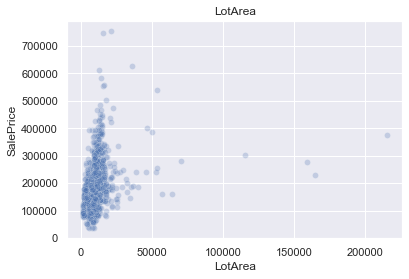

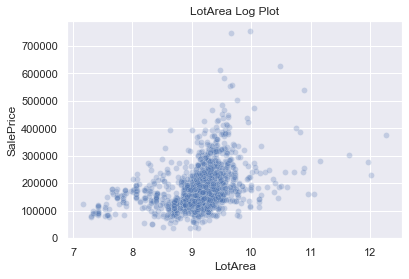

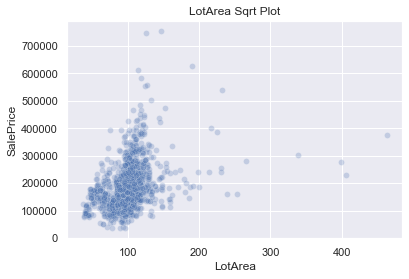

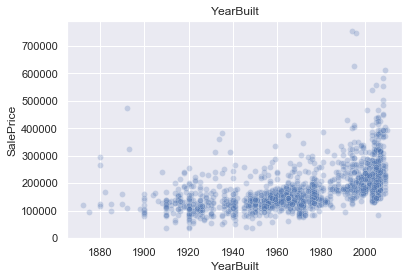

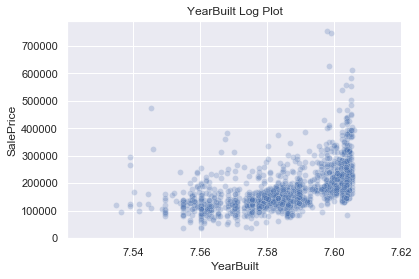

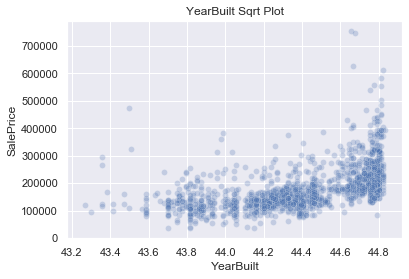

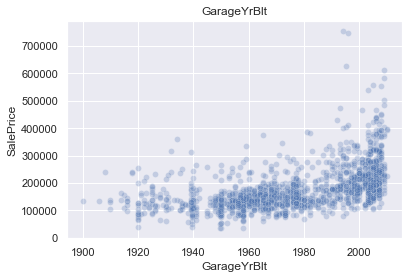

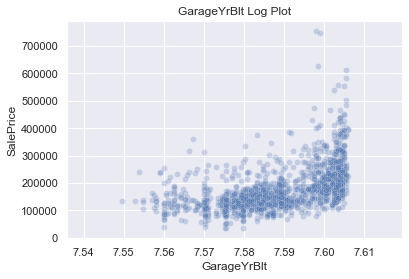

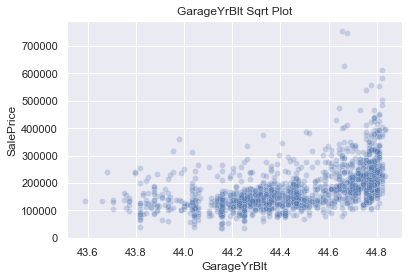

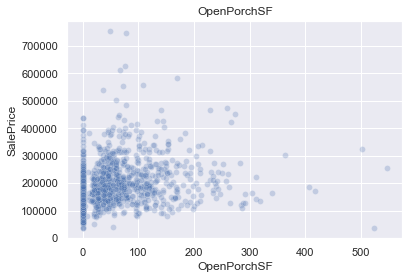

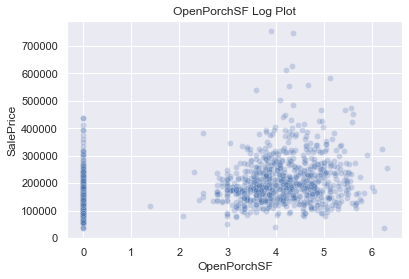

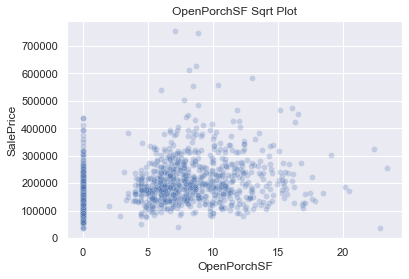

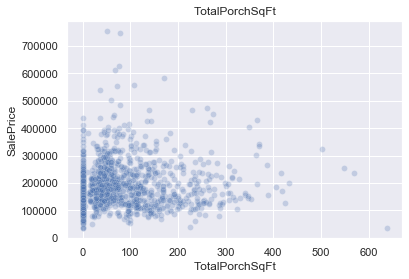

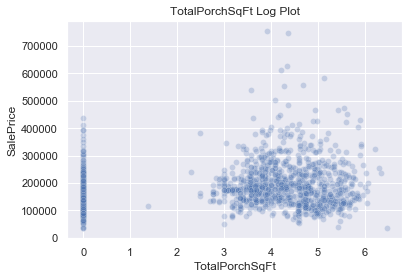

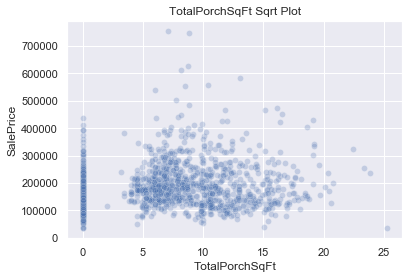

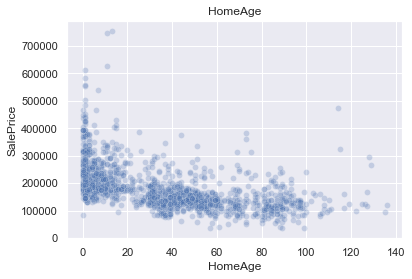

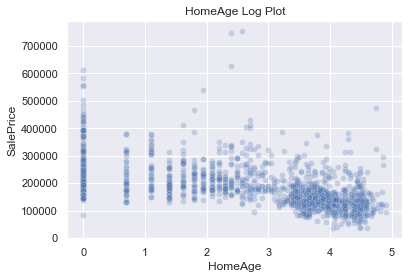

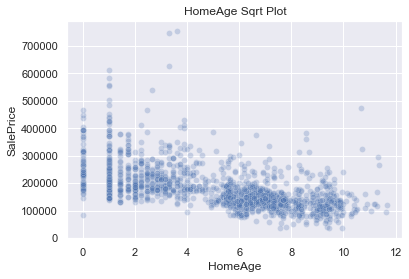

In [271]:
# Now let's loop the above columns and plot them
# We'll plot both the standard, log, and square root transformed versions
for col in corr_diffs_cut.index.to_list():
    
    # Standard plot
    plt.title(col)
    sb.scatterplot(data=df_train, y='SalePrice', x=col, alpha=0.25)
    plt.show()
    
    # Log plot
    plt.title(col + ' Log Plot')
    sb.scatterplot(data=df_train, y='SalePrice', x=df_train[col].apply(lambda x: np.log(x) if x != 0 else 0), alpha=0.25)
    plt.show()
    
    # Sqrt plot
    plt.title(col + ' Sqrt Plot')
    sb.scatterplot(data=df_train, y='SalePrice', x=np.sqrt(df_train[col]), alpha=0.25)
    plt.show()

The only obvious transformation from the above is the `LotArea` field which would better be represented linearly via a log transformation, so we'll handle that below.

In [272]:
# Log transform lot area
df_train['LotArea'] = np.log(df_train.LotArea)
df_test['LotArea'] = np.log(df_train.LotArea)

Since we've created a ton of numerical features by now, it may be worth seeing if we can get rid of any highly correlated ones. It's worth checking a heatmap of the correlations to do so.

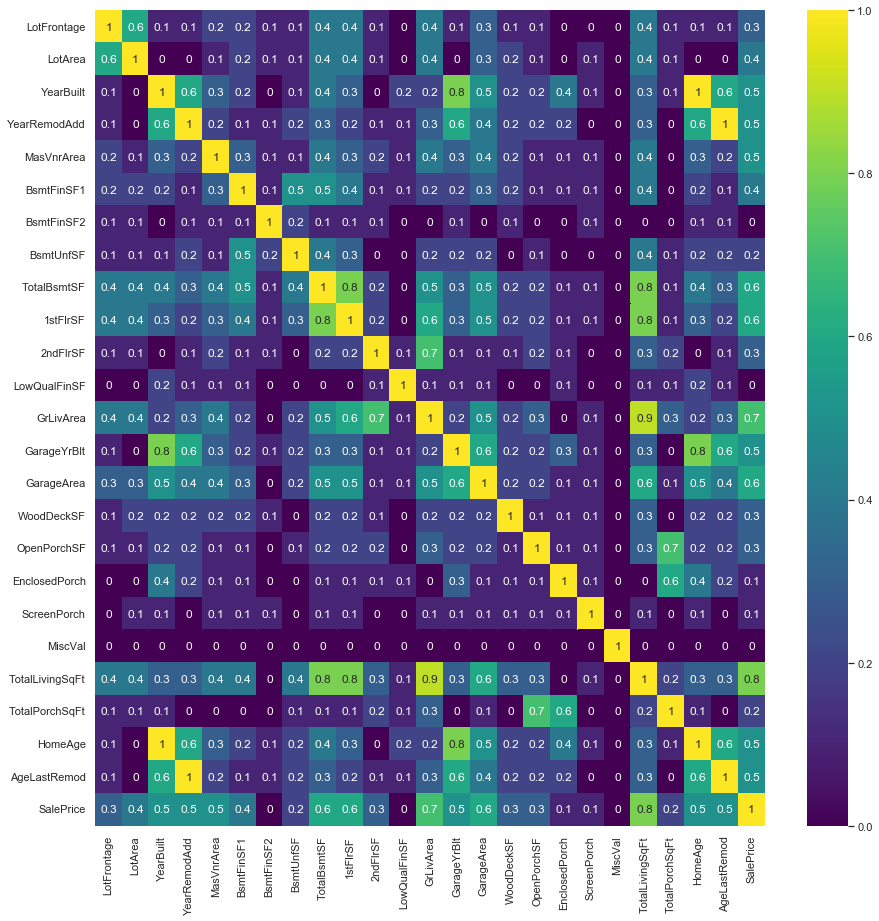

In [273]:
# Create the correlation df
# Also round and absolute value it just to make the correlations easier
corr_numeric = np.abs(np.round(df_train[cols_numeric_nonordinal + ['SalePrice']].corr(), 1))

# Plot the heatmap
plt.figure(figsize=(15, 15))
sb.heatmap(corr_numeric, xticklabels=corr_numeric.columns, yticklabels=corr_numeric.columns, annot=True, cmap='viridis')
plt.show()

Some discussion on the more obvious relationships we see:
* `YearBuild` and `YearRemodAdd` - On one hand there's some high correlations here, but that's simply because the features were created off of each other. Theoretically they carry different information, and features like the year might allow us to account for dollar inflation.
* Square footage columns - There's some high correlations due to feature generation while still carrying different information. Additionally, there's some overlap of variables.

Overall we might have the intuition then to leave the features in given the above, but still it's often taking a look like this to help build our story. Also if we use a non-stochastic tree algorithm (instead of say, linear regression), we don't have quite as much to worry about when it comes to multicollinearity.

Since we had already decided to use a gradient boosted trees algorithm, and since our dataset is relatively small, we might reasonably choose to forgoe much in the way of further feature downselection and rely on regularizing the tree through hyperparameters instead. 

## Model Selection
<a id='ModelSelection'></a>

### Cross Validation Setup
<a id='CrossValidationSetup'></a>

Let's first go ahead and define our features (X) and target (y). We'll go ahead and try and predict the log of y instead so that large and small house prices have ~even effects, but we'll need to remember to undo this at the end.

In [274]:
# Define out features (X) and target (y)
X = df_train.drop(columns=['SalePrice', 'Id'])
y = np.log(df_train.SalePrice)

Now let's define a function to handle cross-validation for us. In this case, it's handy to use our own function since we'd like to try dropping outlier records on the training but not the test set. We'll allow the function to accept the number of folds, a cut-off value for removing outliers (as discussed previously), and a set of possible model hyperparameters.

We're also setting this up just to use a GBT regressor just for keeping the scope of this project simple.

The function below runs an example of this and returns a tuple of the avg rmse score for that run and its standard deviation.

In [275]:
# Define our cross validation evaluation function
def cv_evaluate(X, y, k=5, outlier_cut=None, model_params=None):

    # Define our splitting pattern
    kf = KFold(n_splits=k, shuffle=False)
    cv_iter = 0 # Also a counter for keeping track
    
    # Empty list to append results to
    l_rmse = []
    
    # Loop through the indices
    for train_index, test_index in kf.split(X):
        
        # Update our counter and print iteration
        cv_iter += 1
        print('Iteration {} of {} total folds.'.format(cv_iter, k), end='\r')
        
        # Create dfs using the given indices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # If removing outliers, rebuild new indices for the training data (keep test indices the same)
        if outlier_cut:
        
            mask = np.ones(len(X_train), dtype=bool) # A dummy array to keep track of non-missing values

            for col in cols_numeric_nonordinal:

                # If the median for the column is 0, only look at the nonzero values
                center = X_train[col].median()
                if center == 0:
                    col_data = X_train[col][X_train[col] != 0]
                else:
                    col_data = X_train[col]

                # Fina the IQR ranges
                q25 = np.percentile(col_data, 25)
                q75 = np.percentile(col_data, 75)
                iqr = outlier_cut * (q75 - q25)
                lower, upper = q25 - iqr, q75 + iqr

                # Update the dummary array with which are and aren't outliers
                not_outliers = ~(
                    (X_train[col] != 0) & # Don't consider the 0s in the outlier sets
                    ((X_train[col] < lower) | (X_train[col] > upper))
                    )
                mask = mask & not_outliers
                
            # Now re-establish the train set without the outliers
            X_train, y_train = X_train[mask], y_train[mask]
        
        # Train our model
        # Allow us to not have to pass in explicit model hyperparams
        if model_params:
            reg = XGBRegressor(**model_params, booster='gbtree', verbosity=0)
        else:
            reg = XGBRegressor(booster='gbtree', verbosity=0)
        reg.fit(X_train, y_train, eval_metric='rmse')
        
        # Score our model and append results
        y_pred = reg.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        l_rmse.append(rmse)
    
    # Return the mean rmse and its standard deviation
    return np.mean(l_rmse), np.std(l_rmse)


cv_evaluate(X, y, k=5, outlier_cut=1.5)

(0.15938117636790056, 0.010803829709260497)

But we also want to be able to search hyperparameters using that cross validation function. Let's define a parameter search function that will call `cv_evaluate` itself while looping through various hyperparameter combinations. We'll treat the outlier cuts also as a hyperparameter but set it up so it can be handled separately.

For instance, we'll set it up to search across values like the below.

In [276]:
# Define some example feeder combinations to a practice parameter search
outlier_cuts = [None, 1.5]

params_dict = {
    'n_estimators': [1, 5, 20, 300],
    'learning_rate': [0.05],
    'max_depth': [11]
}

Now let's set up our hyperparameter search function and run a quick example. Since it calls our cross-validation search, we'll need to give it everything that cross validation also needs. Finally we'll have it return a sorted datafrae of our rmse values and the hyperparameter combinations that went with them.

In [277]:
# Define our hyperparameter search function
def param_search(X, y, outlier_cuts, model_params, k=5):
    
    # Create a dictionary that we'll use to keep track of the combination at any given iteration
    # Initialize it with empty lists, these will eventually be appended to and turned into a dataframe
    d_params_tracker = {}
    d_params_tracker['outlier_cut'] = []
    for key in model_params: # We don't know which params we might search over, so this is handled agnostically
        d_params_tracker[key] = []
        
    # Also empty lists to append scores to
    l_rmse_avg = []
    l_rmse_std = []
    
    # Set up a parameter grid of all possible commbinations from model_params
    params_grid = ParameterGrid(model_params)
    total_combs = len(params_grid) * len(outlier_cuts)
    print('{} total combinations selected.'.format(total_combs))
    
    # Set up a counter to keep track
    combo_counter = 0
    
    # Run the iteration (also combined against any outlier cutoff selected)
    for cut in outlier_cuts:
    
        for params in params_grid:
            
            # Increase the counter of our combinations and print
            combo_counter += 1
            print('Started parameter combination {} of {} total.'.format(combo_counter, total_combs))
            
            # Append to our dictionary tracker lists so we know which combinations were used this run
            d_params_tracker['outlier_cut'] = d_params_tracker['outlier_cut'] + [cut]
            for key, value in params.items():
                d_params_tracker[key] = d_params_tracker[key] + [value]
                
            # Run cross validation and get the scores passing in params from above
            rmse_avg, rmse_std = cv_evaluate(X, y, k=k, outlier_cut=cut, model_params=params)
            l_rmse_avg.append(rmse_avg)
            l_rmse_std.append(rmse_std)
            
            # Separate cleanly
            print()
            
    # Add our scores to the params tracker
    d_params_tracker['rmse_avg'] = l_rmse_avg
    d_params_tracker['rmse_std'] = l_rmse_std
            
    return pd.DataFrame(d_params_tracker).sort_values(by='rmse_avg', ascending=True)
                
param_search(X, y, outlier_cuts=outlier_cuts, model_params=params_dict, k=5)

8 total combinations selected.
Started parameter combination 1 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 2 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 3 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 4 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 5 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 6 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 7 of 8 total.
Iteration 5 of 5 total folds.
Started parameter combination 8 of 8 total.
Iteration 5 of 5 total folds.


,outlier_cut,n_estimators,learning_rate,max_depth,rmse_avg,rmse_std
3,NaN,300,0.05,11,0.132006,0.006981
7,1.5,300,0.05,11,0.145467,0.010822
2,NaN,20,0.05,11,4.148925,0.017370
6,1.5,20,0.05,11,4.175148,0.018065
1,NaN,5,0.05,11,8.928014,0.019460
5,1.5,5,0.05,11,8.939982,0.019404
0,NaN,1,0.05,11,10.955605,0.018604
4,1.5,1,0.05,11,10.958269,0.018591


Everything is looking as expected! With that, we can begin tuning.

### Hyperparameter Tuning
<a id='HyperparameterTuning'></a>

Let's start off with a generic run through a reasonable range of likely values for our hyperparameters.

In [67]:
# Set up our search parameters
outlier_cuts = [None, 1.5, 6, 18]

params_dict = {
    'n_estimators': [50, 150, 200, 300],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [5, 7, 13, 15, 35]
}

# Run the search
%time results_df = param_search(X, y, outlier_cuts=outlier_cuts, model_params=params_dict, k=5)
results_df

320 total combinations selected.
Started parameter combination 1 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 2 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 3 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 4 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 5 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 6 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 7 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 8 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 9 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 10 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 11 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 12 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 13 of 320 total.
Itera

Iteration 5 of 5 total folds.
Started parameter combination 107 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 108 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 109 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 110 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 111 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 112 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 113 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 114 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 115 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 116 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 117 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 118 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 119 

Iteration 5 of 5 total folds.
Started parameter combination 212 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 213 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 214 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 215 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 216 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 217 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 218 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 219 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 220 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 221 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 222 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 223 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 224 

Iteration 5 of 5 total folds.
Started parameter combination 317 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 318 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 319 of 320 total.
Iteration 5 of 5 total folds.
Started parameter combination 320 of 320 total.
Iteration 5 of 5 total folds.
Wall time: 23min 29s


,outlier_cut,n_estimators,learning_rate,max_depth,rmse_avg,rmse_std
283,18.0,300,0.050,5,0.128426,0.007739
303,18.0,300,0.100,5,0.129102,0.008955
43,NaN,300,0.050,5,0.129299,0.007700
302,18.0,200,0.100,5,0.129359,0.008832
282,18.0,200,0.050,5,0.129385,0.007835
...,...,...,...,...,...,...
84,1.5,50,0.001,7,10.972061,0.018585
88,1.5,50,0.001,13,10.972061,0.018585
92,1.5,50,0.001,15,10.972061,0.018585
80,1.5,50,0.001,5,10.972061,0.018585


Let's check the top of our results directly.

In [69]:
results_df.head(15)

,outlier_cut,n_estimators,learning_rate,max_depth,rmse_avg,rmse_std
283,18.0,300,0.05,5,0.128426,0.007739
303,18.0,300,0.10,5,0.129102,0.008955
43,NaN,300,0.05,5,0.129299,0.007700
302,18.0,200,0.10,5,0.129359,0.008832
282,18.0,200,0.05,5,0.129385,0.007835
301,18.0,150,0.10,5,0.129715,0.008622
42,NaN,200,0.05,5,0.129999,0.007713
62,NaN,200,0.10,5,0.130187,0.006620
207,6.0,300,0.05,7,0.130231,0.008289
63,NaN,300,0.10,5,0.130349,0.006858


Let's first see if removing outliers seems to have any major effect overall. From the top few of our results, it seems like perhaps it's best to not remove much in the way of outliers.

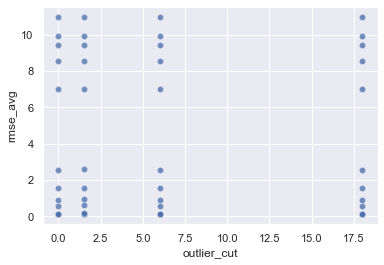

In [70]:
# Outlier cutoff against rmse
sb.scatterplot(data=results_df.fillna(0), x='outlier_cut', y='rmse_avg', alpha=0.25) # We'll say the 0s are no outliers
plt.show()

In [71]:
results_df.fillna('No Cut').groupby('outlier_cut')['rmse_avg'].mean().sort_values()

outlier_cut
18.0      3.279225
No Cut    3.279446
6.0       3.280014
1.5       3.295142
Name: rmse_avg, dtype: float64

Given the above, perhaps either not cutting out outliers or making the cutoff point be very high works best, but there's not a huge impact.

Let's take a look at the number of trees and learning rate against our score to get a sense of any trend we see.

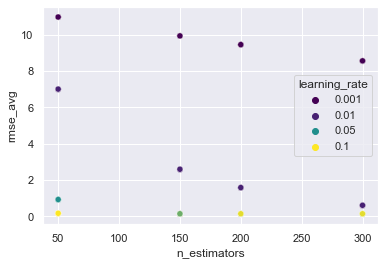

In [72]:
# n_estimators and Learning_rate against the score
sb.scatterplot(data=results_df, x='n_estimators', y='rmse_avg', hue='learning_rate', palette='viridis', alpha=0.5)
plt.show()

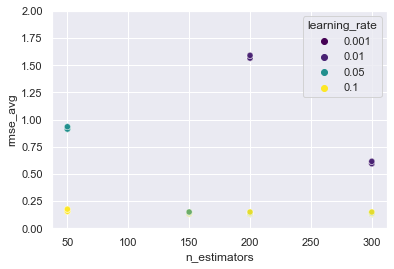

In [73]:
# Zoom in on the smaller scores for finer details
sb.scatterplot(data=results_df, x='n_estimators', y='rmse_avg', hue='learning_rate', palette='viridis', alpha=0.5)
plt.ylim((0, 2))
plt.show()

We're getting a tighet spread of better scores closer to 300, but it does look like with more learners and a lower learning rate we could imagine converging to a better score. The lowest learning rate (0.001) however seems like it would take too long (too many learners) to get there.

Now let's check out the depth of the tree.

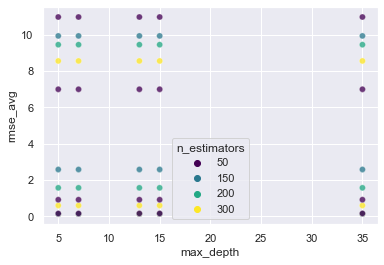

In [74]:
# Depth vs Rmse with number of trees
sb.scatterplot(data=results_df, x='max_depth', y='rmse_avg', hue='n_estimators', palette='viridis', alpha=0.3)
plt.show()

The pattern for depth is not quite so obvious, but we note that all the top scorers have that value as 5 or 7. As such, we'll stick with those and include 3 to test out really simple decision trees just in case.

Let's combine what we've decided on above. For computational complexity and time, let's drop the outlier cutoff as it seems to not make much of a difference. Let's instead however add gamma as a further regularization option. We'll let this be a long one as we expect to likely hit the ceiling of the best we can do after running it.

In [68]:
# Set up our search parameters
outlier_cuts = [None]

params_dict = {
    'n_estimators': [200, 250, 300, 350, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.0001, 0.001, 0.01, 0.05, 0.1]
}

# Run the search
%time results_df_2 = param_search(X, y, outlier_cuts=outlier_cuts, model_params=params_dict, k=5)
results_df_2

324 total combinations selected.
Started parameter combination 1 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 2 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 3 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 4 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 5 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 6 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 7 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 8 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 9 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 10 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 11 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 12 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 13 of 324 total.
Itera

Iteration 5 of 5 total folds.
Started parameter combination 107 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 108 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 109 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 110 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 111 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 112 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 113 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 114 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 115 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 116 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 117 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 118 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 119 

Iteration 5 of 5 total folds.
Started parameter combination 212 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 213 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 214 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 215 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 216 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 217 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 218 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 219 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 220 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 221 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 222 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 223 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 224 

Iteration 5 of 5 total folds.
Started parameter combination 317 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 318 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 319 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 320 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 321 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 322 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 323 of 324 total.
Iteration 5 of 5 total folds.
Started parameter combination 324 of 324 total.
Iteration 5 of 5 total folds.
Wall time: 39min 22s


,outlier_cut,n_estimators,learning_rate,max_depth,gamma,rmse_avg,rmse_std
131,None,500,0.05,3,0.0010,0.126199,0.008092
185,None,500,0.05,3,0.0100,0.126428,0.008166
77,None,500,0.05,3,0.0001,0.126465,0.007627
23,None,500,0.05,3,0.0000,0.126471,0.007500
184,None,400,0.05,3,0.0100,0.126508,0.008115
...,...,...,...,...,...,...,...
108,None,200,0.01,3,0.0010,1.565528,0.012931
162,None,200,0.01,3,0.0100,1.565530,0.012953
54,None,200,0.01,3,0.0001,1.565533,0.012934
0,None,200,0.01,3,0.0000,1.565533,0.012934


It certainly looks like we've hit the peak of about as much as we can get from hyperparameter tuning, but since we introduced a new parameter and the best model is one with even more trees, let's do some quick plotting to make sure we're not missing out.

In [75]:
# Top models
results_df_2.head(20)

,outlier_cut,n_estimators,learning_rate,max_depth,gamma,rmse_avg,rmse_std
131,None,500,0.05,3,0.0010,0.126199,0.008092
185,None,500,0.05,3,0.0100,0.126428,0.008166
77,None,500,0.05,3,0.0001,0.126465,0.007627
23,None,500,0.05,3,0.0000,0.126471,0.007500
184,None,400,0.05,3,0.0100,0.126508,0.008115
130,None,400,0.05,3,0.0010,0.126581,0.008013
76,None,400,0.05,3,0.0001,0.126643,0.007811
183,None,350,0.05,3,0.0100,0.126661,0.007981
22,None,400,0.05,3,0.0000,0.126798,0.007715
75,None,350,0.05,3,0.0001,0.126879,0.007995


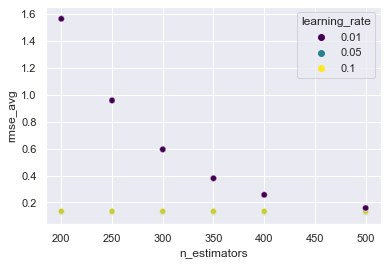

In [76]:
# Estimators vs rmse with learning rate
sb.scatterplot(data=results_df_2, x='n_estimators', y='rmse_avg', hue='learning_rate', palette='viridis', alpha=0.3)
plt.show()

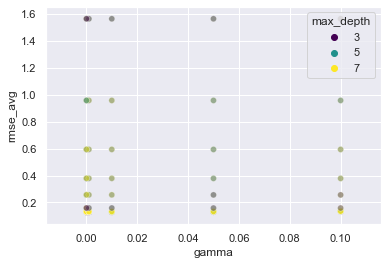

In [77]:
# Gamma vs rmse with max depth
sb.scatterplot(data=results_df_2, x='gamma', y='rmse_avg', hue='max_depth', palette='viridis', alpha=0.3)
plt.show()

In [78]:
# Avg gammas
results_df_2.groupby('gamma')['rmse_avg'].mean().sort_values()

gamma
0.0001    0.303652
0.0100    0.303768
0.0000    0.303826
0.0010    0.303987
0.0500    0.304786
0.1000    0.306585
Name: rmse_avg, dtype: float64

There's not an obvious pattern with the gammas, albeit a seemingly slight improvement. Using very small trees (max depth of 3) does seem helpful though. Let's do one more just to see if we can eek out a little more with learning rate and number of trees.

In [79]:
# Set up our search parameters
outlier_cuts = [None]

params_dict = {
    'n_estimators': [500, 550, 600, 650, 750],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3],
    'gamma': [0.0010]
}

# Run the search
%time results_df_3 = param_search(X, y, outlier_cuts=outlier_cuts, model_params=params_dict, k=5)
results_df_3

10 total combinations selected.
Started parameter combination 1 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 2 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 3 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 4 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 5 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 6 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 7 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 8 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 9 of 10 total.
Iteration 5 of 5 total folds.
Started parameter combination 10 of 10 total.
Iteration 5 of 5 total folds.
Wall time: 1min 18s


,outlier_cut,n_estimators,learning_rate,max_depth,gamma,rmse_avg,rmse_std
5,None,500,0.05,3,0.001,0.126199,0.008092
8,None,650,0.05,3,0.001,0.126208,0.007808
7,None,600,0.05,3,0.001,0.126276,0.007857
6,None,550,0.05,3,0.001,0.126278,0.008027
9,None,750,0.05,3,0.001,0.126448,0.007743
4,None,750,0.01,3,0.001,0.131229,0.006697
3,None,650,0.01,3,0.001,0.134258,0.006207
2,None,600,0.01,3,0.001,0.137489,0.005968
1,None,550,0.01,3,0.001,0.144163,0.005579
0,None,500,0.01,3,0.001,0.158820,0.005237


It definitely looks like we've maxxed out now. Let's fit the model on our whole training set using the best hyperparameters from above.

In [283]:
# Fit the final model
X = df_train.drop(columns=['SalePrice', 'Id'])
y = np.log(df_train.SalePrice)
reg = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, gamma=0.001, booster='gbtree', verbosity=0)
reg.fit(X, y, eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.001, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

## Model Prediction
<a id='ModelPrediction'></a>

Now we can predict on the test set, reverse the log, and submit!

In [ ]:
# Final predictions
X_test = df_test.drop(columns=['Id'])
y_log = reg.predict(X_test)
y = np.exp(y_log)

# Export the predictions
df_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice':y})
df_submission.to_csv('submission.csv', index=False)

Submitting that gives us a RMSLE of ~0.348. That's almost double our cross-validation score, but remember we were being quick and allowed test set leakage across the folds via imputation! That's a good reminder of of the significance, but that wasn't the intention of this notebook. Also, interestingly, if we exponentiate that difference to get it back in dollars, we get...

In [285]:
np.exp(0.34832)

1.4166855165787666

... which shows surprisingly reasonable performance for predicting a home price on some quick work! There's probably a noteworthy error in the above, but all the same!